In [1]:
import ipyparallel as ipp
from ipyparallel import Client

cluster = ipp.Cluster(n = 8)
# await cluster.start_cluster()
cluster.start_cluster_sync()
# or cluster.start_cluster_sync() without await
# Using existing profile dir: '/Users/X/.ipython/profile_default'
# Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>

# clusters = ipp.ClusterManager().load_clusters() 

Starting 8 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


<Cluster(cluster_id='1717668069-bl7k', profile='default', controller=<running>, engine_sets=['1717668070'])>

In [4]:
rc = Client(profile = "default", cluster_id = '1717668069-bl7k')

# Classification

### This chapter will look into classification using the famous MNIST dataset, which contains images of handwriten digits. Fortunately, each image is labelled

In [41]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_openml

## Importing and Exploring the Dataset

In [4]:
mnist = fetch_openml("mnist_784", version = 1, as_frame=False)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's explore some of the keys, to get a better idea of the dataset.

In [6]:
mnist["DESCR"]

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [7]:
mnist["data"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [8]:
mnist["target"]

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [9]:
X, y = mnist["data"], mnist["target"] ## extract the features and the labels

X.shape

(70000, 784)


The target is the number the image represents, which is a simple integre. The data has 70,000 images (stored as 70,000 rows) and each image is a 28x28 image (784 colunns) which store a value between 0 and 255, for white and black respectively. 


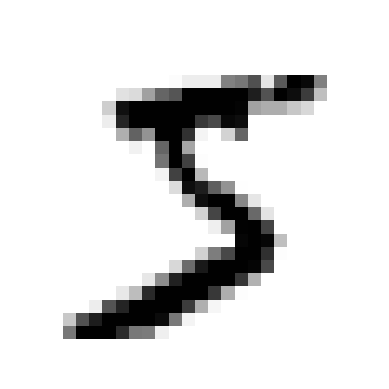

In [10]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [11]:
y = y.astype(np.uint8) ## convert the strings to numbers
y[0] ## the image is labelled as 5, and it looks like a 5

5

# Training a Binary Classifier

Before we jump into multi-class classification, let's focus on the principles of classification in a more simple context. The simpliest is likely the binary classification problem. Let's follow the book and use 5 as the target, and all other values will be denoted by 0. That means we are trying to find if a number is actually 5 or not, without caring what the other number is - like the difference between 1 and 7. 

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's comvert our label into a binary value

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5  ## BOOLEAN array

array([ True, False, False, ...,  True, False, False])

### Stochastic Gradient Descent (SGD)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([ some_digit ]) ## input is 5, output is true!!

array([ True])

### Measuring Performance

#### Accuracy

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

The issue with using accuracy with classification is we need to compare it to a baseline. With our data, the classification is naturally skewed, as 90% of the data is not the digit 5. So a score greater than 90% is only a marginal increase.

It is usually better to consider more than one metric, like precision and recall. Precision is how many times do we say the image is 5 correctly vs all the times we said it - i.e 

- TP / (TP + FP) - where FP is all the times we said 5 but it wasn't a real 5.

We could artifially get perfect precision if we only guessed a single image as 5 - but we would need to be correct. This overlooks how images of the digit 5 we have missed. Recall is how well we captured all the number 5 in our data - i.e

- TP / (TP + FN) - where FN is all the times we said a digit wasn't a 5 but when it actually was. 

#### Confusion Matrix

First, we need to make predictions before we generate the confusion matrix, as we need to compare what the model *"thinks"* compared to the genuine label. This can give us the four pieces of information we need: the number of **False Positives**, **False Negatives**, **True Positives** and **True Negatives**. 


|   |REAL|FAKE|
|---|----|----|
|POS| TP | FP |
|NEG| FN | TN |


In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred) ## 53,892 TN and 3530 TP but 1,891 False Positives (false alarms) and 687 False Negatives (misses)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
print(f"Precision of the Model is: {(3530 / (3530 + 687)):.3f}%")
print(f"Recall of the Model is: {(3530 / (3530 + 1891)):.3f}%")

Precision of the Model is: 0.837%
Recall of the Model is: 0.651%


In [20]:
## we can import from sklearn so we don't need to do this manually, but look how they return the same results.
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### F1 Score

We can combine the two metrics into a ratio or a score. If we want to say that precision and recall are equally important to our problem, then we can use the harmonic mean of the two metrics:

F1 = 2 x ( ( Precision x recall )/ ( Precision + Recall ) )

It is important to note that in order to get a high F1 score, max is 1, we need to have high precision and recall - it is the combination of both this is important. 

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

#### Precision/Recall Trade-off

Under the hood, classification algorithms typically generate a score for each instance which is then compared to a threshold. If the value is above the threshold it is a positive class, else it is negative class. This score is generated from the **decision function** which can be accessed directly from `model.decision_function()`. 

In [28]:
y_scores= sgd_clf.decision_function([some_digit])
y_scores ## array([2164.220...])
# sgd_clf.predict([some_digit]) ## TRUE
y_scores > 0 ## TRUE

array([ True])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [30]:
y_scores.shape ## (60000, )
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [31]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

(-50000.0, 50000.0, 0.0, 1.0)

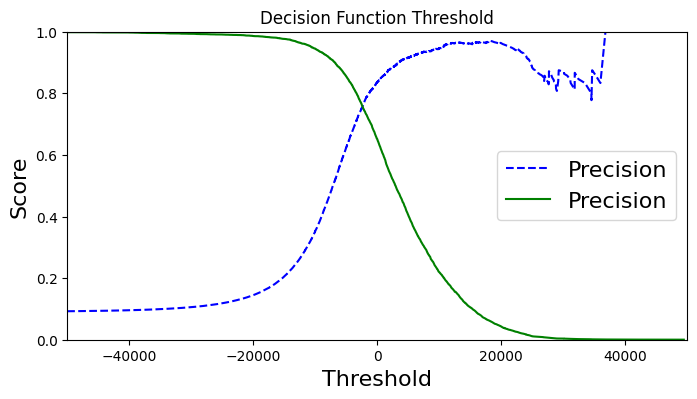

In [32]:
plt.figure(figsize=(8, 4)) 
plt.plot(threshold, precision[:-1], "b--", label = "Precision")
plt.plot(threshold, recall[:-1], "g-", label = "Precision")
plt.xlabel("Threshold", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.title("Decision Function Threshold")
plt.axis([-50000, 50000, 0, 1]) ## sets the limits of the plot

Here the trade-off is very clear, when the threshold (shown on the X axis) increases, the recall decrease - as less images are being scored as the positive class, which inflates the false negatives. Conversely, the precision increases because we have fewer false positives, again due to the decrease in the images being scored as the positive class. 

We can use this graph to estimate what threshold we would need to obtain a certain precision or recall, let's say a precision of 90%. It would be more accurate to obtain this using code or maths instead of graphically. 

In [33]:
ind = np.argmax(precision >= .9)
threshold_90 = threshold[ind]
recall_90 = recall[ind]
# precision >= .9 returns a vector of True and False values. 
# np.argmax(precision >= .9) returns the index of the first TRUE value, as FALSE is being treated as zero. 
threshold_90 ## ~ 3370.01

3370.0194991439557

In [34]:
## Let's just verify the recall and precision to make sure we do have a precision of 90%
y_train_pred_90 = (y_scores >= threshold_90)
precision_score(y_train_5, y_train_pred_90) ## 90.00346%
recall_score(y_train_5, y_train_pred_90) ## 47.99852%

0.4799852425751706

(0.0, 1.0, 0.0, 1.0)

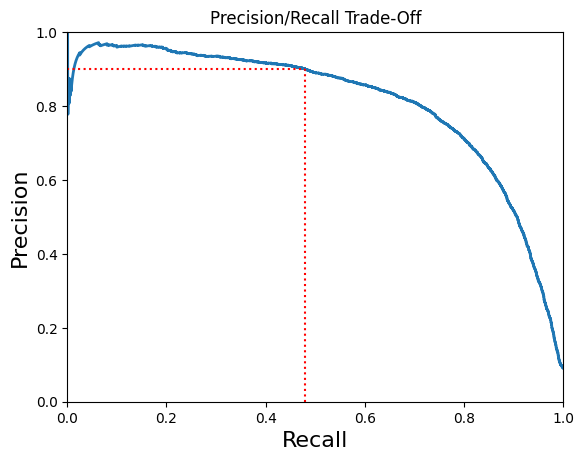

In [35]:
plt.plot(recall, precision, linewidth = 2)
plt.plot([0, recall_90], [0.9, 0.9], "r:")
plt.plot([recall_90, recall_90], [0.0, 0.9], "r:")
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Precision/Recall Trade-Off")
plt.axis([0, 1, 0, 1]) ## sets the limits of the plot

#### ROC Curve

The **Reciever operating characteristic** curve is very similar to the precision/recall curve, but it shows the *true positive rate* (recall) against the *false positive rate*. The *FPR* is 1 - the *TNR*, which is sometimes called *specificity*. Therefore the ROC is the Sensitivity of the Model vs 1 - Specificity of the model. 

Note the *TNR* is TN / (TN + FP) - a ratio about all the negative instances, so FP is when the negative is marked as a positive.

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

(0.0, 1.0, 0.0, 1.0)

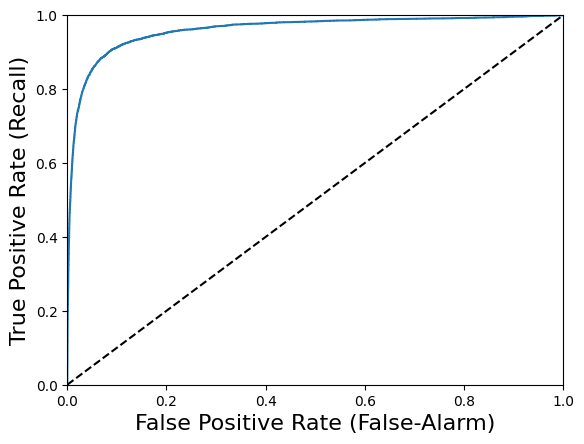

In [37]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel('False Positive Rate (False-Alarm)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.axis([0, 1, 0, 1])

#### AUC 

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC Curve and Precision/Recall curve are generally quite similar, there is usually no need to do both. It is preferred to use the Precision/Recall curve when the positive is uncommon or when the false positive rate is more important than the false negative rate. The ROC may look very impressive, but the precision/recall curve illustrates the weakness in the models performance, as it is further away from the borders.

### Random Forest 

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 5)

## RandomForest does not have a decision_function() method, so we use the predict_proba() one instead -
## this gives us the instance the instance belongs to the positive class. 
## Returns one row per instance, and one colomn per class
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [40]:
y_proba_forest.shape ## 60,000 instances, and 2 classes!!
y_proba_forest[0]  ## 10% not a 5, 90% it is a five (it is a 5)

array([0.1, 0.9])

To draw the ROC curve, we need the false positive and true positive rate, which is calculated from the model making a decision, but we do not have the decision function to give us a score. We can use the positive class probability in it's place - as the highest probability for each instance is used to classify it. 

In [42]:
forest_y_scores = y_proba_forest[:, 1]

forest_fpr, forest_tpr, forest_threshold  = roc_curve(y_train_5, forest_y_scores)

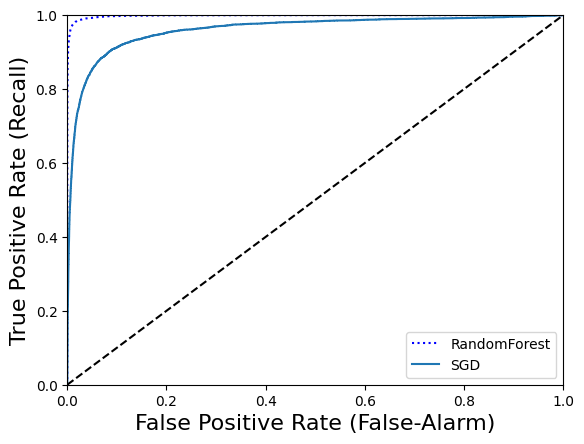

In [43]:
plt.plot(forest_fpr, forest_tpr, "b:", label = "RandomForest")
plt.plot(fpr, tpr, label = "SGD")
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel('False Positive Rate (False-Alarm)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.axis([0, 1, 0, 1])
plt.show()

#### ROC AUC Score

In [44]:
roc_auc_score(y_train_5, forest_y_scores)

0.9983655237419137

#### Precision

In [45]:
forest_y_scores_5 = forest_y_scores > .5

precision_score(y_train_5, forest_y_scores_5)

0.988686360779384

#### Recall

In [46]:
recall_score(y_train_5, forest_y_scores_5)

0.8705035971223022

## Testing how to parse the cv_results_ when scoring = None

In [59]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
cv = cross_validate(
    estimator = forest_clf, 
    X =  X_train, 
    y = y_train_5, 
    cv = 2, 
    scoring = {"acc" : "accuracy", "none" : None}, 
    n_jobs = -2
)

In [58]:
cv.items()

dict_items([('fit_time', array([9.6507709 , 9.22605896])), ('score_time', array([0.76499557, 0.75463891])), ('test_acc', array([0.98693333, 0.98566667])), ('test_none', array([0.98693333, 0.98566667]))])

In [76]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=5)

In [99]:
y_pred = forest_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average = None, labels = range(0, 10))

In [300]:
cm = confusion_matrix(y_test, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

cm

array([[ 970,    0,    1,    0,    0,    1,    3,    1,    3,    1],
       [   0, 1124,    2,    2,    1,    1,    2,    1,    2,    0],
       [   7,    0,  996,    7,    3,    0,    4,    8,    7,    0],
       [   1,    0,   10,  974,    0,    6,    0,    9,    8,    2],
       [   1,    0,    1,    0,  952,    0,    4,    0,    4,   20],
       [   2,    0,    0,   15,    2,  855,   10,    1,    5,    2],
       [   8,    3,    1,    0,    2,    5,  935,    0,    4,    0],
       [   2,    2,   21,    2,    1,    0,    0,  985,    4,   11],
       [   4,    0,    7,    8,    4,    4,    4,    3,  930,   10],
       [   6,    5,    1,   11,   16,    1,    1,    4,    8,  956]],
      dtype=int64)

In [186]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print(TP, FP, FN, TN)

[ 970 1124  996  974  952  855  935  985  930  956] [31 10 44 45 29 18 28 27 45 46] [10 11 36 36 30 37 23 43 44 53] [8989 8855 8924 8945 8989 9090 9014 8945 8981 8945]


In [ ]:
## i = row (true), j = column (predicted)
## TP is when i == j
tp = cm[0, 0] ## i, j

## FP is when we get the sum of the column - and subtract TP
fp = cm[:, 0].sum() - tp

## FN is when we get the sum of the rom - and subtract the TP
fn = cm[0, :].sum() - tp

## TN is the sum of the entire matrix, minis the TP, FP and FN
cm.sum() - (tp + fp + fn)

## in form {class : values}
## where values is in the form 
## {tp = tp, tn = tn, fp = fp, fn = fn}

In [270]:
def label_confusion_values(confusion_matrix, index):
    cm = confusion_matrix
    ## TP is when i == j
    tp = cm[index, index] ## i, j
    
    ## FP is when we get the sum of the column - and subtract TP
    fp = cm[:, index].sum() - tp
    
    ## FN is when we get the sum of the rom - and subtract the TP
    fn = cm[index, :].sum() - tp
    
    ## TN is the sum of the entire matrix, minis the TP, FP and FN
    tn = cm.sum() - (tp + fp + fn)

    out = {"tp" : float(tp), "fp" : float(fp), "tn" : float(tn), "fn" : float(fn)}
    
    return out


def confusionMatrix_scoring(y, y_pred):

    cm = confusion_matrix(y, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    return {"class_" + str(i) : label_confusion_values(cm, i) for i in range(len(cm))}

In [313]:


def generate_extractor(metric, index):

    def extract_class_metric(y, y_pred):

        cm = confusion_matrix(y, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

        cm_dict = label_confusion_values_2(cm)
        values = cm_dict[metric]
        
        return values[index]

    return extract_class_metric

def confusionMatrix_scoring_2(y, y_pred):
   
    cm = confusion_matrix(y, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    cm_dict = label_confusion_values_2(cm)
    
    return out


cm_dict = label_confusion_values_2(cm)

print(cm_dict)

get_c0_tp = generate_extractor("tp", 0)
get_c0_tp(y_test, y_pred)

{'tp': array([ 970, 1124,  996,  974,  952,  855,  935,  985,  930,  956],
      dtype=int64), 'fp': array([31, 10, 44, 45, 29, 18, 28, 27, 45, 46], dtype=int64), 'tn': array([8989, 8855, 8924, 8945, 8989, 9090, 9014, 8945, 8981, 8945],
      dtype=int64), 'fn': array([10, 11, 36, 36, 30, 37, 23, 43, 44, 53], dtype=int64)}


970

In [314]:
functions = {}

for key in cm_dict.keys():
    for label in range(0, 10):
        k = str(key) + "_" + str(label)
        functions[k] = make_scorer(generate_extractor(key, label), greater_is_better=True)

functions

{'tp_0': make_scorer(extract_class_metric, response_method='predict'),
 'tp_1': make_scorer(extract_class_metric, response_method='predict'),
 'tp_2': make_scorer(extract_class_metric, response_method='predict'),
 'tp_3': make_scorer(extract_class_metric, response_method='predict'),
 'tp_4': make_scorer(extract_class_metric, response_method='predict'),
 'tp_5': make_scorer(extract_class_metric, response_method='predict'),
 'tp_6': make_scorer(extract_class_metric, response_method='predict'),
 'tp_7': make_scorer(extract_class_metric, response_method='predict'),
 'tp_8': make_scorer(extract_class_metric, response_method='predict'),
 'tp_9': make_scorer(extract_class_metric, response_method='predict'),
 'fp_0': make_scorer(extract_class_metric, response_method='predict'),
 'fp_1': make_scorer(extract_class_metric, response_method='predict'),
 'fp_2': make_scorer(extract_class_metric, response_method='predict'),
 'fp_3': make_scorer(extract_class_metric, response_method='predict'),
 'fp_4

In [278]:
# {"class_" + str(i) : label_confusion_values(cm, i) for i in range(len(cm))}

In [269]:
label_confusion_values_2(cm)

[array([ 970, 1124,  996,  974,  952,  855,  935,  985,  930,  956],
       dtype=int64),
 array([31, 10, 44, 45, 29, 18, 28, 27, 45, 46], dtype=int64),
 array([8989, 8855, 8924, 8945, 8989, 9090, 9014, 8945, 8981, 8945],
       dtype=int64),
 array([31, 10, 44, 45, 29, 18, 28, 27, 45, 46], dtype=int64)]

In [ ]:
from sklearn.metrics import make_scorer


In [306]:
def label_confusion_values_2(confusion_matrix):
    import numpy as np
    cm = confusion_matrix
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    out = {"tp" : TP, "fp" : FP, "tn" : TN, "fn" : FN}
    
    return out

def confusionMatrix_scoring_2(y, y_pred):
   
    cm = confusion_matrix(y, y_pred, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    out = label_confusion_values_2(cm)
    
    return out

scorer = make_scorer(confusionMatrix_scoring_2, greater_is_better=True)

In [322]:
params = {"n_estimators" : [10, 20, 30]}

gcv = GridSearchCV(
    estimator = forest_clf, 
    param_grid = params, 
    cv = 5, 
    scoring = functions, 
    refit = False, 
    n_jobs = -2)

gcv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5), n_jobs=-2,
             param_grid={'n_estimators': [10, 20, 30]}, refit=False,
             scoring={'fn_0': make_scorer(extract_class_metric, response_method='predict'),
                      'fn_1': make_scorer(extract_class_metric, response_method='predict'),
                      'fn_2': make_scorer(extract_class_metric, response_method='predict'),
                      'fn_3': make_...
                      'tn_4': make_scorer(extract_class_metric, response_method='predict'),
                      'tn_5': make_scorer(extract_class_metric, response_method='predict'),
                      'tn_6': make_scorer(extract_class_metric, response_method='predict'),
                      'tn_7': make_scorer(extract_class_metric, response_method='predict'),
                      'tn_8': make_scorer(extract_class_metric, response_method='predict'),
                      'tn_9': make_scorer(extract_class_metric, response_method='predict'), ...})

In [293]:
scorer(forest_clf, X_test, y_test)
# f1_score(y_test, y_pred, average = None)

967.7

In [323]:
gcv.cv_results_

{'mean_fit_time': array([15.65921817, 25.27188005, 30.60079241]),
 'std_fit_time': array([0.49478355, 0.5641131 , 0.07753259]),
 'mean_score_time': array([0.48403339, 0.40743914, 0.279106  ]),
 'std_score_time': array([0.13999586, 0.08318933, 0.02407267]),
 'param_n_estimators': masked_array(data=[10, 20, 30],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 20}, {'n_estimators': 30}],
 'split0_test_tp_0': array([1156., 1164., 1164.]),
 'split1_test_tp_0': array([1165., 1169., 1173.]),
 'split2_test_tp_0': array([1160., 1168., 1167.]),
 'split3_test_tp_0': array([1153., 1165., 1166.]),
 'split4_test_tp_0': array([1162., 1169., 1171.]),
 'mean_test_tp_0': array([1159.2, 1167. , 1168.2]),
 'std_test_tp_0': array([4.26145515, 2.0976177 , 3.31058907]),
 'rank_test_tp_0': array([3, 2, 1]),
 'split0_test_tp_1': array([1321., 1322., 1322.]),
 'split1_test_tp_1': array([1330., 1333., 1335.]),
 'spli

# Training A Multiclass Classifier

Not all classifiers can automatically support multiclass problems, for example Support Vector Machines and Logistic Regression are both suited for binary classification. However, Naive Bayes, Random Forest and SGD are natively mutliclass. This means if you want to use a binary classifer, you would have to reform the multiclass problem as multiple binary problems. For example, using the *One-versus-the-Rest (OvR)* or *One-versus-One(OvO)*. The latter is usually more computational intensive, as it pairs each class to another. So if you have *N* classes, you need (*N* x *N* - 1) / 2 pairs. As we have 10 digits in the MNIST data, that means we would need to train 45 classifiers. The alternative is the *OvR* where we train *N* classifiers, which are trained to detect one class from the rest, and we select the highest scoring one. Generally, *OvR* is preferred by sometimes *OvO* is a practical option as it reduces each training set. This means for algorithms like SVM, which do not scale efficiently, it is easier to train many small classifiers than a handful of large ones.   

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()

In [ ]:
svm_clf.fit(X_train, y_train) ## sklearn will automatically use One vs One as we are using a SVM - so this is actually training 45 models
# svm_clf.predict([some_digit]) ## it should return with a 5


In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores ## notive how it returns N number of values instead of 1. As it has a score for each class - not classifier. 

In [ ]:
i = np.argmax(some_digit_scores) ## the position of the largest class
svm_clf.classes_[i] ## in out case, the 5th class is the number 5!

We can explicitly control which form Sci-kit uses, here we specify the OnevsRest version of the classifier. 

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
ovr_clf = OneVsRestClassifier(SVC(random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_) ## the number of classifiers

In [ ]:
sgd_clf.fit(X_train, y_train) ## SGD handles multiclass natively. 
sgd_clf.predict([some_digit])

If we run the decision function now, we get a value for each class, again the highest value is the class which is selected.

In [ ]:
sgd_clf.decision_function([some_digit]) ## see how the argument for 5 is the largest.

In [ ]:
from sklearn.preprocessing import StandardScaler

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

In [ ]:
This chapter does not go through the same steps as the previous, we should still transform our data as it typically improves scores, 
then effectivly search the space of parameters to fine tune a handful of candidate models before narrowing it down further.

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scale, y_train, cv = 3, scoring = "accuracy")

## Error Analysis

In [ ]:
%%timeit
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=11):
   
    y_train_pred = cross_val_predict(sgd_clf, X_train_scale, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

In [ ]:
%%timeit
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=2):
   
    y_train_pred = cross_val_predict(sgd_clf, X_train_scale, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = "true")
plt.show()

The above matrix is find but it shows the absolute number of errors instead of the relative rate of errors, which allows us to compare them better. Let's get the number of all the real classes (in the rows) so that we aren't unfairly evaluating the more abundant classes. This is how to do it manually, but sklearn has a handy argument for us called normalize.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx[0]

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = "true", include_values = False)
plt.show()

In [ ]:
## let's remove the correct values, as the might be hiding the more common errors as the range of colours is not great. 
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx)
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx)
fig.colorbar(cax)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.show()

In [37]:
## CODE FROM THEIR NOTEBOOK
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 8, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] ## an 8 is predicted as an 8
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] ## an 8 is predicted as a 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] ## a 5 predicted as an 8
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] ## a 5 predicted as an 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# MultiLabel Classification

In [2]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] 

In [29]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [30]:
knn_clf.predict([some_digit]) 

array([[False,  True]])

# Multioutput Classification 

This is an extension of multilabel as we allow a prediction to return multiple labels, but each label can itself be more than one value.
The example in the book is removing noise from an image - as the output is a set of labels, representing every pixel, which can have multiple values ranging from 0 to 255.

In [32]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test
some_index = 0

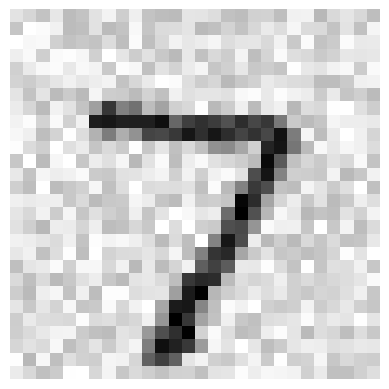

In [49]:
plot_digit(X_test_mod[0])

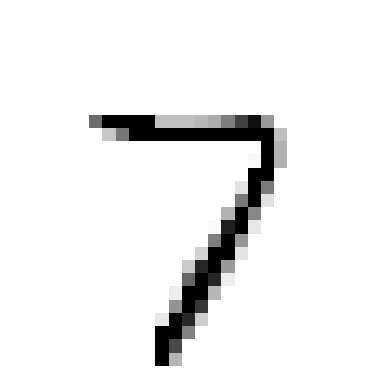

In [42]:


knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
